# LLM - Claude - Anthropic - AWS

De todos los modelos de Anthropic, el modelo `Claude 3 Haiku` es el único que puede ser Fine Tuneado en Amazon Bedrock. El objetivo de este notebook es realizar y describir dicho proceso con nuestro conjunto de datos de interés.

Guía tomada de: https://aws.amazon.com/es/blogs/machine-learning/fine-tune-anthropics-claude-3-haiku-in-amazon-bedrock-to-boost-model-accuracy-and-quality/


## Libraries


In [15]:
import pandas as pd
import json

## Dataset

Se cargan los datasets de `training`, `validation` y `test` que se han utilizado en otros modelos para garantizar consistencia al momento de comparar los resultados. Cada uno de estos datasets contiene dos variables **text** y **emotion**


In [2]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [3]:
df_train.head()

,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


## Prepare Data

La data debe estar almacenada en S3 en el formato aceptado por la API:

{"system": string, "messages": [{"role": "user", "content": string}, {"role": "assistant", "content": string}]}

Por ejemplo:

{
"system": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.",
"messages": [
{"role": "user", "content": "instruction:\n\nSummarize the news article provided below.\n\ninput:\nSupermarket customers in France can add airline tickets to their shopping lists thanks to a unique promotion by a budget airline. ... Based at the airport, new airline launched in 2007 and is a low-cost subsidiary of the airline."},
{"role": "assistant", "content": "New airline has included voucher codes with the branded products ... to pay a booking fee and checked baggage fees ."}
]
}


In [21]:
system_message = """You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger]."""


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['text']}\n\nWhat is the emotion expressed in this text?"


# Function to prepare an example conversation
def prepare_example_conversation(row):
    return {
        "system": system_message,
        "messages": [
            {"role": "user", "content": create_user_message(row)},
            {
                "role": "assistant",
                "content": row["emotion"],
            },  # Emotion label from your dataset
        ],
    }


# Process each row of the dataframe
conversations = df_train.apply(prepare_example_conversation, axis=1)

# Save the results to a JSONL file
with open("../data/data_to_finetune_claude/isear_train.jsonl", "w") as jsonl_file:
    conversations.apply(lambda x: jsonl_file.write(json.dumps(x) + "\n"))

# Output a confirmation message
print("Training Data successfully saved to isear_train.jsonl")

Training Data successfully saved to isear_train.jsonl


In [22]:
# Process each row of the dataframe
conversations = df_val.apply(prepare_example_conversation, axis=1)

# Save the results to a JSONL file
with open("../data/data_to_finetune_claude/isear_val.jsonl", "w") as jsonl_file:
    conversations.apply(lambda x: jsonl_file.write(json.dumps(x) + "\n"))

# Output a confirmation message
print("Training Data successfully saved to isear_train.jsonl")

Training Data successfully saved to isear_train.jsonl


## Fine Tuning `claude3-haiku`

A la fecha de este desarrollo, el proceso de Fine-Tuning de los modelos de Anthropic solo están disponibles através de **AWS Bedrock** en la region **us-west2 (Oregon)** y se puede lograr realizando los siguientes pasos:

### 1. Almacenar la data preparada en S3

- Crear un bucket de s3 con los folders _training_, _validation_ y _outputs_. Luego, publicar en los buckets los datos de entrenamiento y validación en formato _.jsonl_. El folder _outputs_ es necesario para almacenar los resultados del proceso de fine-tuning.

### 2. Crear el job de fine-tuning en Amazon Bedrock

- En Amazon Berock dirigirse a Custom models y crear un Fine-tuning job
  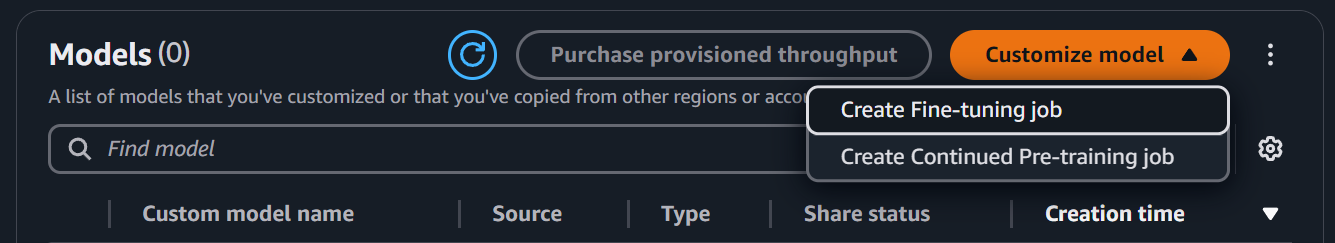

- En la ventana de configuración del modelo:
  - Seleccionar en modelo: model provider = Anthropic, Mode= Claude 3 Haiku.
  - Agregar un nombre al modelo y al job.
  - Confiugurar en **input data** las rutas de los conjuntos de datos de _training_ y _validation_ de S3.
  - Configurar en **Hyperparameters** los parámetros deseados en el proceso de Fune-tuning, en este caso, se configuran así:
    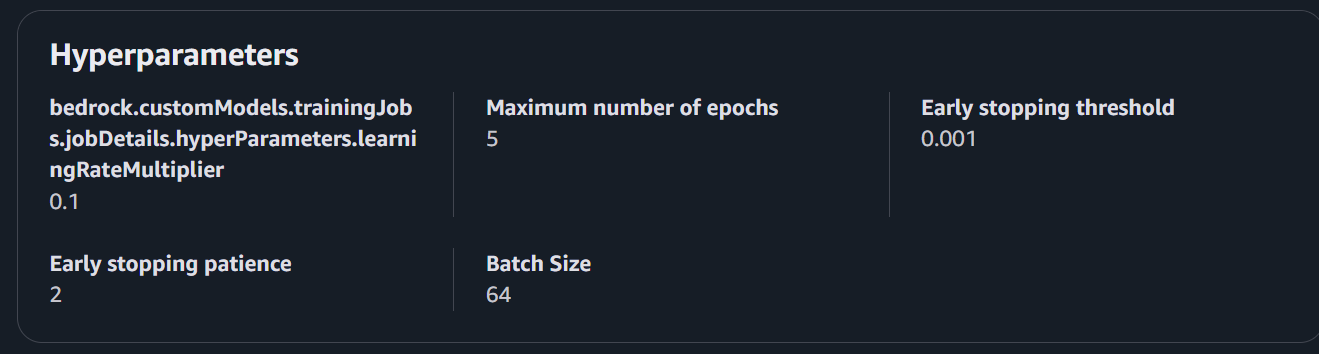
  - Configurar en **output data** la ruta del folder de s3 donde se guardarán los resultados.
- Crear el job de fine-tuning. Una vez creado, se podrá ver en la ventana de Custom models el job en ejecución.
  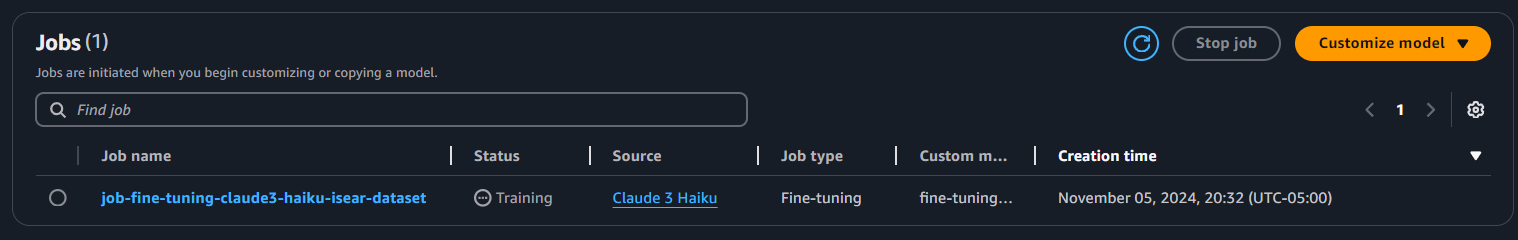

Todo este proceso también se puede realiza con el _Software Develpment Kid_ de AWS utilizando python, para más información ver https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-code-samples.html

### 3. Configurar pre-requitisos para usar el modelo fine-tuneado

Una vez que el job cambia a estado "Complete", se pueden ver los detalles del proceso de entrenamiento en el folder _outputs_ de S3.
Se debe comprar **Provisioned Throughput for Amazon Bedrock** (https://docs.aws.amazon.com/bedrock/latest/userguide/prov-throughput.html) para poder usar el modelo personalizado.
